In [652]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [653]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from itertools import product
from itertools import combinations
import pickle
import datetime

from ete3 import Tree
import torch.nn as nn
from torch.distributions.log_normal import LogNormal

import subprocess
import os

from scipy.special import logsumexp

from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from io import StringIO
from Bio import Phylo

import warnings

warnings.filterwarnings('ignore')

from copy import deepcopy
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.cluster.hierarchy import *


np.random.seed(0)

In [670]:
data_set = "DS3"
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/'+data_set+'/'+data_set+'.pickle'
time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
reparam_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reparam.pickle'
reinforce_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reinforce.pickle'
VIMCO_file = '../results/'+data_set+'/'+data_set+'_'+time+'_VIMCO.pickle'

In [671]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [672]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
ntaxa = len(species)

In [673]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.], 'n':[1.,1.,1.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

# set $\theta$ using BEAST empirical values

In [674]:
treedata = ""
ntrees = 0

for i in range(2):
    
    tree_file = "../dat/"+data_set+"/"+data_set+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)

    with open(tree_file, "r") as file:
        for line in file:
            if line.startswith("tree STATE"):

                # start at first (
                line = line[line.find('('):]

                # remove 
                line = line.replace("[&rate=1.0]","")

                # print line
                #print(line)

                treedata = treedata + line + "\n"

                ntrees += 1

In [675]:
theta = torch.zeros((2,ntaxa,ntaxa))
trees = Phylo.parse(StringIO(treedata), "newick")
log_dists = np.zeros((ntrees,ntaxa,ntaxa))

for i,tree in enumerate(trees):
    print(i/ntrees)
    for j in range(ntaxa):
        for k in range(j):
            log_dists[i,j,k] = np.log(tree.distance(target1=str(j+1),target2=str(k+1))/2.0)

for j in range(ntaxa):
    for k in range(j):
        theta[0,j,k] = np.mean(log_dists[:,j,k])
        theta[1,j,k] = np.log(np.std(log_dists[:,j,k]))


#treedata = write_newick(tree.nodes[-1])
#handle = StringIO(treedata)
#tree_to_draw = Phylo.read(handle, "newick")

0.0
0.0004995004995004995
0.000999000999000999
0.0014985014985014985
0.001998001998001998
0.0024975024975024975
0.002997002997002997
0.0034965034965034965
0.003996003996003996
0.004495504495504496
0.004995004995004995
0.005494505494505495
0.005994005994005994
0.006493506493506494
0.006993006993006993
0.007492507492507493
0.007992007992007992
0.008491508491508492
0.008991008991008992
0.00949050949050949
0.00999000999000999
0.01048951048951049
0.01098901098901099
0.011488511488511488
0.011988011988011988
0.012487512487512488
0.012987012987012988
0.013486513486513486
0.013986013986013986
0.014485514485514486
0.014985014985014986
0.015484515484515484
0.015984015984015984
0.016483516483516484
0.016983016983016984
0.017482517482517484
0.017982017982017984
0.01848151848151848
0.01898101898101898
0.01948051948051948
0.01998001998001998
0.02047952047952048
0.02097902097902098
0.02147852147852148
0.02197802197802198
0.022477522477522476
0.022977022977022976
0.023476523476523476
0.023976023976023

0.2072927072927073
0.2077922077922078
0.2082917082917083
0.2087912087912088
0.20929070929070928
0.2097902097902098
0.2102897102897103
0.21078921078921078
0.2112887112887113
0.21178821178821178
0.2122877122877123
0.2127872127872128
0.21328671328671328
0.2137862137862138
0.21428571428571427
0.21478521478521478
0.2152847152847153
0.21578421578421578
0.2162837162837163
0.21678321678321677
0.21728271728271728
0.2177822177822178
0.21828171828171827
0.21878121878121878
0.2192807192807193
0.21978021978021978
0.2202797202797203
0.22077922077922077
0.22127872127872128
0.2217782217782218
0.22227772227772227
0.22277722277722278
0.22327672327672327
0.22377622377622378
0.2242757242757243
0.22477522477522477
0.22527472527472528
0.22577422577422576
0.22627372627372627
0.22677322677322678
0.22727272727272727
0.22777222777222778
0.22827172827172826
0.22877122877122877
0.22927072927072928
0.22977022977022976
0.23026973026973027
0.23076923076923078
0.23126873126873126
0.23176823176823177
0.232267732267732

0.4190809190809191
0.4195804195804196
0.42007992007992007
0.4205794205794206
0.4210789210789211
0.42157842157842157
0.42207792207792205
0.4225774225774226
0.4230769230769231
0.42357642357642356
0.4240759240759241
0.4245754245754246
0.42507492507492506
0.4255744255744256
0.4260739260739261
0.42657342657342656
0.4270729270729271
0.4275724275724276
0.42807192807192807
0.42857142857142855
0.4290709290709291
0.42957042957042957
0.43006993006993005
0.4305694305694306
0.43106893106893107
0.43156843156843155
0.4320679320679321
0.4325674325674326
0.43306693306693306
0.43356643356643354
0.4340659340659341
0.43456543456543456
0.43506493506493504
0.4355644355644356
0.43606393606393606
0.43656343656343655
0.4370629370629371
0.43756243756243757
0.43806193806193805
0.4385614385614386
0.43906093906093907
0.43956043956043955
0.44005994005994004
0.4405594405594406
0.44105894105894106
0.44155844155844154
0.4420579420579421
0.44255744255744256
0.44305694305694304
0.4435564435564436
0.44405594405594406
0.4

0.6378621378621379
0.6383616383616384
0.6388611388611388
0.6393606393606394
0.6398601398601399
0.6403596403596403
0.6408591408591409
0.6413586413586414
0.6418581418581418
0.6423576423576424
0.6428571428571429
0.6433566433566433
0.6438561438561439
0.6443556443556444
0.6448551448551448
0.6453546453546454
0.6458541458541458
0.6463536463536463
0.6468531468531469
0.6473526473526473
0.6478521478521478
0.6483516483516484
0.6488511488511488
0.6493506493506493
0.6498501498501499
0.6503496503496503
0.6508491508491508
0.6513486513486514
0.6518481518481518
0.6523476523476524
0.6528471528471529
0.6533466533466533
0.6538461538461539
0.6543456543456544
0.6548451548451548
0.6553446553446554
0.6558441558441559
0.6563436563436563
0.6568431568431569
0.6573426573426573
0.6578421578421578
0.6583416583416584
0.6588411588411588
0.6593406593406593
0.6598401598401599
0.6603396603396603
0.6608391608391608
0.6613386613386614
0.6618381618381618
0.6623376623376623
0.6628371628371629
0.6633366633366633
0.6638361638

0.8541458541458542
0.8546453546453546
0.8551448551448552
0.8556443556443556
0.8561438561438561
0.8566433566433567
0.8571428571428571
0.8576423576423576
0.8581418581418582
0.8586413586413586
0.8591408591408591
0.8596403596403597
0.8601398601398601
0.8606393606393606
0.8611388611388612
0.8616383616383616
0.8621378621378621
0.8626373626373627
0.8631368631368631
0.8636363636363636
0.8641358641358642
0.8646353646353646
0.8651348651348651
0.8656343656343657
0.8661338661338661
0.8666333666333667
0.8671328671328671
0.8676323676323676
0.8681318681318682
0.8686313686313686
0.8691308691308691
0.8696303696303697
0.8701298701298701
0.8706293706293706
0.8711288711288712
0.8716283716283716
0.8721278721278721
0.8726273726273727
0.8731268731268731
0.8736263736263736
0.8741258741258742
0.8746253746253746
0.8751248751248751
0.8756243756243757
0.8761238761238761
0.8766233766233766
0.8771228771228772
0.8776223776223776
0.8781218781218781
0.8786213786213786
0.8791208791208791
0.8796203796203796
0.8801198801

In [676]:
theta.shape

torch.Size([2, 36, 36])

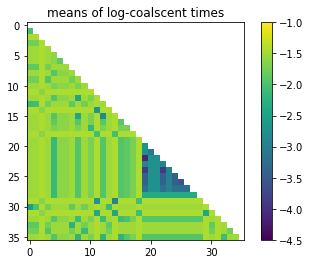

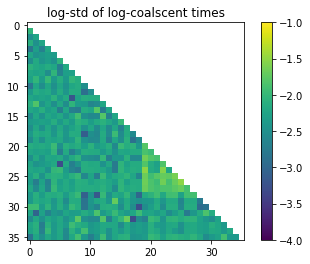

In [677]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin=-4.5,vmax=-1)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig, vmin = -4, vmax=-1)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [678]:
def decompJC(symm=False):
    # pA = pG = pC = pT = .25
    pden = np.array([.25, .25, .25, .25])
    rate_matrix_JC = 1.0/3 * np.ones((4,4))
    for i in range(4):
        rate_matrix_JC[i,i] = -1.0
    
    if not symm:
        D_JC, U_JC = np.linalg.eig(rate_matrix_JC)
        U_JC_inv = np.linalg.inv(U_JC)
    else:
        D_JC, W_JC = np.linalg.eigh(np.dot(np.dot(np.diag(np.sqrt(pden)), rate_matrix_JC), np.diag(np.sqrt(1.0/pden))))
        U_JC = np.dot(np.diag(np.sqrt(1.0/pden)), W_JC)
        U_JC_inv = np.dot(W_JC.T, np.diag(np.sqrt(pden)))
    
    return D_JC, U_JC, U_JC_inv, rate_matrix_JC

D,U,U_inv,rate_matrix = decompJC()

pden = np.array([0.25,0.25,0.25,0.25])
pden = torch.from_numpy(pden).double()
D = torch.from_numpy(D).double()
U = torch.from_numpy(U).double()
U_inv = torch.from_numpy(U_inv).double()

In [679]:
def initialCLV(genomes, unique_site=False):
    if unique_site:
        data_arr = np.array([list(genome) for genome in genomes]).T
        unique_sites, counts = np.unique(data_arr, return_counts=True, axis=0)
        n_unique_sites = len(counts)
        unique_data = unique_sites.T

        return [np.transpose([nuc2vec[c] for c in unique_data[i]]) for i in range(ntaxa)], counts
    else:
        return [np.transpose([nuc2vec[c] for c in data[i]]) for i in range(ntaxa)]

L, site_counts = map(torch.DoubleTensor, initialCLV(genomes, unique_site=True))
    
def loglikelihood(tree,branch):
        
    branch_D = torch.einsum("i,j->ij", (branch, D))
    transition_matrix = torch.matmul(torch.einsum("ij,kj->kij", (U, torch.exp(branch_D))), U_inv).clamp(0.0)
    scaler_list = []
    for node in tree.traverse("postorder"):
        if node.is_leaf():
            node.state = L[node.name].detach()
        else:
            node.state = 1.0
            for child in node.children:
                node.state *= transition_matrix[child.name].mm(child.state)
            scaler = torch.sum(node.state, 0)
            node.state /= scaler
            scaler_list.append(scaler)

    scaler_list.append(torch.mm(pden.view(-1,4), tree.state).squeeze())
    logll = torch.sum(torch.stack(scaler_list).log() * site_counts)
    return logll

def scipy_linkage_to_ete3(linkage_matrix):
    """
    Converts a SciPy hierarchical clustering linkage matrix to an ETE3 tree.

    Parameters:
        linkage_matrix (ndarray): The linkage matrix from scipy.cluster.hierarchy.linkage.
        labels (list of str): Labels for the original leaves (samples).
    
    Returns:
        ete3.Tree: The converted ETE3 tree.
        branches: tensor of branch lengths
    """
    num_leaves = len(linkage_matrix) + 1
    nodes = {i: Tree(name=i,dist=0.0) for i in range(num_leaves)}  # Initialize leaf nodes
    # add torch dist
    for key in nodes:
        nodes[key].dist_torch = torch.tensor(0.0)
        
    branches = torch.zeros(2*num_leaves-2) # Initialize branches
    
    for i, (left, right, distance, _) in enumerate(linkage_matrix):
        left, right = int(left), int(right)  # Convert indices to integers
        new_node = Tree(name=num_leaves+i)  # Create an internal node
        new_node.dist_torch = distance  # Set branch length
        new_node.add_child(nodes[left])  # Add left child
        new_node.add_child(nodes[right])  # Add right child
        for child in new_node.children:
            child.branch = distance - child.dist_torch
            branches[child.name] = child.branch
            
        nodes[num_leaves + i] = new_node  # Store the new node in the dictionary

    nodes[len(linkage_matrix) + num_leaves - 1].branch = None
    tree = nodes[len(linkage_matrix) + num_leaves - 1] 
    return tree, branches

def logvariational(linkage_matrix,theta):
     
    log_q = 0.0
    X = [torch.tensor([i]) for i in range(ntaxa)]
    
    for row in linkage_matrix:
        
        Wn = X[int(row[0])]
        Zn = X[int(row[1])]
        t = row[2]
        log_t = torch.log(t)
        
        Wn_grid, Zn_grid = torch.meshgrid(Wn,Zn, indexing='ij')
        rowinds = torch.max(Wn_grid.flatten(), Zn_grid.flatten())
        colinds = torch.min(Wn_grid.flatten(), Zn_grid.flatten())
        
        mus = theta[0,rowinds,colinds]
        sigs = torch.exp(theta[1,rowinds,colinds])
        
        dist = LogNormal(mus, sigs)
        
        log_sfs = torch.log(1.0 - dist.cdf(t))
        log_pdfs = dist.log_prob(t)
        
        log_q += torch.sum(log_sfs) + torch.logsumexp(log_pdfs - log_sfs,0)
            
        X.append(torch.cat([Wn,Zn]))
        
    return log_q

def logvariational0(linkage_matrix,theta):
     
    log_q = 0.0
    X = [{i} for i in range(ntaxa)]
    
    for row in linkage_matrix:
        
        Wn = X[int(row[0])]
        Zn = X[int(row[1])]
        t = row[2]
        log_t = torch.log(t)
        
        log_pdfs_over_sfs = torch.zeros(len(Wn)*len(Zn))
        log_cum_sfs = 0.0
        
        for k,(w,z) in enumerate(product(Wn,Zn)):
            
            # find parameters
            i = max(w,z)
            j = min(w,z)
            mu = theta[0,i,j]
            log_sig = theta[1,i,j]
            sig = torch.exp(log_sig)
            dist = LogNormal(mu, sig)

            # calculate q and Q
            log_sf = torch.log(1.0 - dist.cdf(t))
            log_pdf = dist.log_prob(t)

            # update log_q
            log_cum_sfs += log_sf
            log_pdfs_over_sfs[k] = log_pdf - log_sf
            
        # update log q
        log_q += log_cum_sfs + torch.logsumexp(torch.flatten(log_pdfs_over_sfs),0)
            
        X.append(Wn.union(Zn))
        
    return log_q

In [680]:
ntaxa
theta0 = theta.clone()

In [681]:
theta = nn.Parameter(torch.tensor(theta0, requires_grad=True))

optimizer = torch.optim.Adam([theta], lr=0.01)
ct = datetime.datetime.now()

#print(theta)

niter = 1000
batch_size = 10

for it in range(niter):

    logll = 0.0
    logprior = 0.0
    logq = 0.0
    
    for _ in range(batch_size):
    
        eps = torch.normal(mean=0.0,std=1.0,size=(ntaxa,ntaxa))
        times = torch.exp(torch.exp(theta[1])*eps+theta[0])
        times = times + torch.triu(torch.full((ntaxa,ntaxa), float("Inf")))
        times0 = times.detach().numpy()
        Z = linkage([times0[ind[1],ind[0]] for ind in combinations(range(ntaxa),2)], method="single")
        Z = torch.tensor(Z)

        # find the right inds
        rowinds,colinds = np.where(np.isin(times0,Z[:,2]))
        Z[:,2] = torch.sort(times[rowinds,colinds])[0]

        # find log-priors
        ts = torch.diff(Z[:,2],prepend=torch.tensor([0.0]))
        ks = torch.tensor(range(ntaxa,1,-1))
        rates = ks*(ks-1) / (2*pop_size)
        logprior = logprior + torch.sum(torch.log(rates) - rates*ts - torch.log(ks*(ks-1)/2))/batch_size

        # get log-likelihood
        tree,branches = scipy_linkage_to_ete3(Z)
        logll = logll + loglikelihood(tree,branches)/batch_size
        
        # get log-q
        logq = logq + logvariational(Z,theta)/batch_size
        
    loss = -logll-logprior+logq

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if it % (niter/10) == 0:
        print(it/niter,loss)
    
print(datetime.datetime.now() - ct)
print(theta)

0.0 tensor(34174.5730, grad_fn=<AddBackward0>)
0.1 tensor(33925.0864, grad_fn=<AddBackward0>)
0.2 tensor(33829.8731, grad_fn=<AddBackward0>)
0.3 tensor(33825.5676, grad_fn=<AddBackward0>)
0.4 tensor(33800.9036, grad_fn=<AddBackward0>)
0.5 tensor(33800.1943, grad_fn=<AddBackward0>)
0.6 tensor(33797.8120, grad_fn=<AddBackward0>)
0.7 tensor(33798.0554, grad_fn=<AddBackward0>)
0.8 tensor(33796.7830, grad_fn=<AddBackward0>)
0.9 tensor(33796.7744, grad_fn=<AddBackward0>)
0:08:24.623716
Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.9890,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1308, -1.1362,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-1.8689, -1.6518, -1.1408,  ...,  0.0000,  0.0000,  0.0000],
         [-1.5463, -1.5366, -1.1389,  ..., -1.4835,  0.0000,  0.0000],
         [-1.2338, -1.2385, -1.1611,  ..., -1.2245, -1.2772,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,

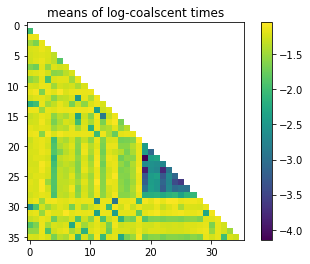

In [682]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

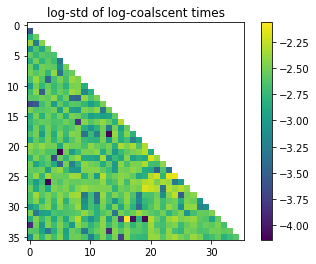

In [683]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [669]:
treedata = write_newick(tree1.nodes[-1])
handle = StringIO(treedata)
tree_to_draw = Phylo.read(handle, "newick")

# Set up the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

# Draw the phylogenetic tree
Phylo.draw(tree_to_draw, axes=ax)

NameError: name 'write_newick' is not defined

# test gradient

In [363]:
from ete3 import Tree
import torch.nn as nn

theta0 = theta.detach().clone()
theta0[1] = -2*torch.ones_like(theta0[1])
theta = nn.Parameter(torch.tensor(theta0, requires_grad=True))

optimizer = torch.optim.Adam([theta], lr=0.01)
ct = datetime.datetime.now()

#print(theta)

torch.manual_seed(0)
niter = 1
batch_size = 1

for it in range(niter):

    logll = 0.0
    logprior = 0.0
    
    for _ in range(batch_size):
    
        eps = torch.normal(mean=0.0,std=1.0,size=(ntaxa,ntaxa))
        log_times = torch.exp(theta[1])*eps+theta[0]
        log_times = log_times + torch.triu(torch.full((ntaxa,ntaxa), float("Inf")))
        log_times0 = log_times.detach().numpy()
        Z = linkage([np.exp(log_times0[ind[1],ind[0]]) for ind in combinations(range(ntaxa),2)], method="single")
        Z = torch.tensor(Z)

        # find the right inds
        rowinds,colinds = np.where(np.isin(np.exp(log_times0),Z[:,2]))
        Z[:,2] = torch.exp(torch.sort(log_times[rowinds,colinds])[0])

        #logll += torch.sum(Z[:,2])
        # find log-priors
        ts = torch.diff(Z[:,2],prepend=torch.tensor([0.0]))
        ks = torch.tensor(range(ntaxa,1,-1))
        rates = ks*(ks-1) / (2*pop_size)
        logprior = logprior + torch.sum(torch.log(rates) - rates*ts - torch.log(ks*(ks-1)/2))/batch_size

        tree,branches = scipy_linkage_to_ete3(Z)
        logll = logll + loglikelihood(tree,branches)/batch_size
        
    loss = -logll-logprior

    optimizer.zero_grad()
    loss.backward()
    #optimizer.step()

print(theta.grad[0,12,8])
#print(datetime.datetime.now() - ct)
#print(theta)

tensor(0.8037)


In [359]:
from ete3 import Tree
import torch.nn as nn

#theta = torch.zeros_like(theta)
theta = nn.Parameter(torch.tensor(theta, requires_grad=True))
#optimizer = torch.optim.Adam([theta], lr=0.01)
ct = datetime.datetime.now()

#print(theta)

def loss0(theta):

    torch.manual_seed(0)
    niter = 1
    batch_size = 1
    
    logll = 0.0
    logprior = 0.0
    
    for _ in range(batch_size):
    
        eps = torch.normal(mean=0.0,std=1.0,size=(ntaxa,ntaxa))
        log_times = torch.exp(theta[1])*eps+theta[0]
        log_times = log_times + torch.triu(torch.full((ntaxa,ntaxa), float("Inf")))
        log_times0 = log_times.detach().numpy()
        Z = linkage([np.exp(log_times0[ind[1],ind[0]]) for ind in combinations(range(ntaxa),2)], method="single")
        Z = torch.tensor(Z)

        # find the right inds
        rowinds,colinds = np.where(np.isin(np.exp(log_times0),Z[:,2]))
        Z[:,2] = torch.exp(torch.sort(log_times[rowinds,colinds])[0])

        # find log-priors
        ts = torch.diff(Z[:,2],prepend=torch.tensor([0.0]))
        ks = torch.tensor(range(ntaxa,1,-1))
        rates = ks*(ks-1) / (2*pop_size)
        logprior = logprior + torch.sum(torch.log(rates) - rates*ts - torch.log(ks*(ks-1)/2))/batch_size

        tree,branches = scipy_linkage_to_ete3(Z)
        logll = logll + loglikelihood(tree,branches)/batch_size
    
    return -logll-logprior


with torch.no_grad():
    h = 0.000001
    f0 = loss0(theta)
    #print("")
    theta[0,12,8] += h
    f1 = loss0(theta)
    theta[0,12,8] -= h

    print((f1-f0)/h)

tensor(0.0139)


# perform variational inference

In [72]:
optim_reparam = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reparam.learn(batch_size=10,
                    iters=100,
                    alpha=0.01,
                    method="reparam",
                    record_every=10,
                    pop_size=pop_size)

print("final theta:",optim_reparam.theta)
print("final gradient:",optim_reparam.theta.grad)
plt.plot(optim_reparam.ELBO_ests)

KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reparam.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reparam.grad_norms))
plt.show()

m = deepcopy(optim_reparam.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reparam.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [131]:
with open(reparam_file, 'wb') as file: 
    pickle.dump(optim_reparam, file) 

PicklingError: Can't pickle <class 'SLCVI_torch.SLCVI'>: it's not the same object as SLCVI_torch.SLCVI

In [132]:
optim_reinforce = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reinforce.learn(batch_size=10,
                      iters=1000,
                      alpha=0.01,
                      method="reinforce",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
print("final gradient:",optim_reinforce.theta.grad)
plt.plot(optim_reinforce.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  817.5942544636462
ELBO estimate:  -7499.582463637448



KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reinforce.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reinforce.grad_norms))
plt.show()

m = deepcopy(optim_reinforce.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_reinforce, file) 

In [ ]:
optim_VIMCO = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_VIMCO.learn(batch_size=10,
                  iters=1000,
                  alpha=0.01,
                  method="VIMCO",
                  record_every=10,
                  test_batch_size=100,
                  pop_size=pop_size)

print("final theta:",optim_VIMCO.theta)
print("final gradient:",optim_VIMCO.theta.grad)
plt.plot(optim_VIMCO.ELBO_ests)

In [ ]:
plt.plot(optim_VIMCO.ELBO_ests)
plt.show()
plt.plot(np.log(optim_VIMCO.grad_norms))
plt.show()

m = deepcopy(optim_VIMCO.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_VIMCO.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_VIMCO, file) 

In [102]:
optim = optim_reinforce
theta = optim.theta

# draw the random tree using a newick file

In [250]:
def write_newick(node):

    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)
    
for _ in range(10):
    Z = torch.normal(mean=0.0,std=1.0,size=(ntaxa,ntaxa))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((ntaxa,ntaxa), float("Inf")))

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like.item())
    print(tree.log_prior.item())
    print(tree.log_p.item())

TypeError: __init__() got an unexpected keyword argument 'pop_size'

# Estimate the marginal likelihood

In [103]:
n_exp = 10
n_samples = 100

# get priors and log-liklihoods
priors = []
LL = []

# get log_qs
log_qs = []

# get root heights
rootHeights = []

# get tree topologies
tree_hash = {}
top_counts = {}

# get marginal log-likelihoods and ELBOs
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp)

with torch.no_grad():
    for i in range(n_exp):

        print(i)
        MLL = np.zeros(n_samples)
        ELBO = np.zeros(n_samples)

        for j in range(n_samples):
            Z = torch.normal(mean=0.0,std=1.0,size=(ntaxa,ntaxa))
            log_times = torch.exp(theta[1])*Z+theta[0]
            log_times = log_times + torch.triu(torch.full((ntaxa,ntaxa), float("Inf")))
            tree = Tree(optim.theta,
                        log_times,
                        deepcopy(tree_log_probs),
                        pop_size=pop_size)

            MLL[j] = tree.log_p.item() - tree.log_q.item()
            ELBO[j] = tree.log_p.item() - tree.log_q.item()

            LL.append(tree.log_like.item())
            priors.append(tree.log_prior.item())
            log_qs.append(tree.log_q.item())
            rootHeights.append(tree.nodes[-1].coal_time.item())

            tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
            if tree_top in tree_hash:
                top_counts[tree_hash[tree_top]] += 1
            else:
                tree_hash[tree_top] = len(tree_hash)
                top_counts[tree_hash[tree_top]] = 1

        MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
        ELBO_all[i] = np.mean(ELBO)

0
1
2
3
4
5
6
7
8
9


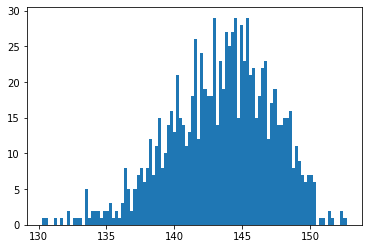

143.46433505458214


In [104]:
plt.hist(log_qs,bins = 100)
plt.show()
print(np.mean(log_qs))

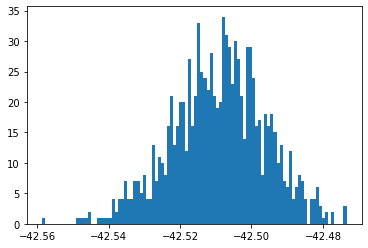

-42.50910236394554


In [105]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

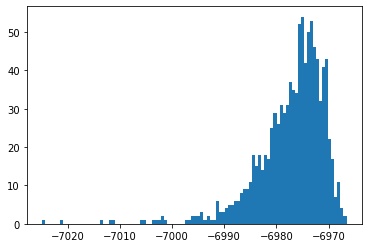

-6977.177121521376


In [106]:
plt.hist(LL,bins = 100)
plt.show()
print(np.mean(LL))

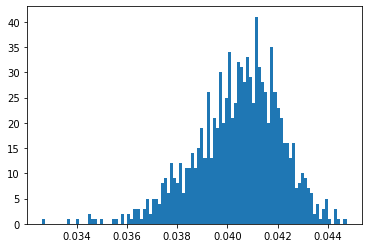

0.04042246175528179


In [107]:
plt.hist(rootHeights,bins = 100)
plt.show()
print(np.mean(rootHeights))

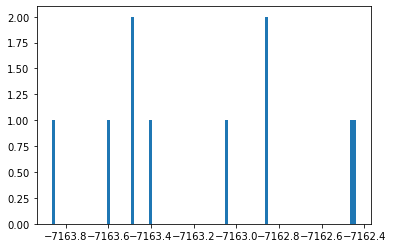

-7163.150558939904


In [108]:
plt.hist(ELBO_all,bins = 100)
plt.show()
print(np.mean(ELBO_all))

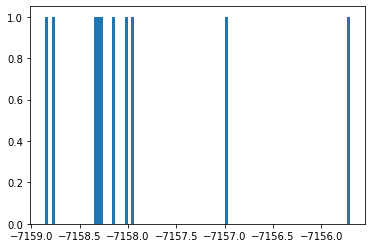

-7157.934354856084


In [109]:
plt.hist(MLL_all,bins = 100)
plt.show()
print(np.mean(MLL_all))

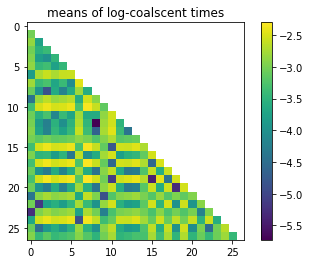

In [110]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

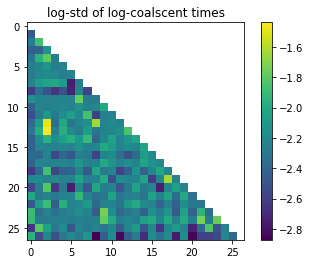

In [111]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()